# Import Libraries

In [1]:
# Essential Configuration
%matplotlib inline
%config InlineBackend.figure_formats = {'retina', 'svg'}

# Core Libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from matplotlib import colors as mcolors
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)


# Scikit-learn Libraries

from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline


# Display Settings
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Adjust the display width to accommodate all columns

# Seaborn Default Settings
sns.set(
    {
        "figure.figsize": (8, 6)
    },
    style='ticks',
    color_codes=True,
    font_scale=0.8
)


In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt


# 1.0 Data Understanding and Exploratory Data Analysis (EDA)
# 1.1 Load Dataset 

In [33]:
# Load dataset
df = pd.read_csv('video_games_sales.csv')

# Display first five rows
df.head()


,Category,Month,Monthly Sales,Year,DayOfWeek,Platform,Holiday,Promotion
0,Sports,2002-01-01,108592,2002,1,Xbox,1,0
1,RPG,2002-02-01,129387,2002,4,Nintendo,0,0
2,Sports,2002-03-01,114777,2002,4,PC,0,0
3,Sports,2002-04-01,71738,2002,0,Nintendo,0,0
4,Simulation,2002-05-01,142512,2002,2,PlayStation,0,0


# 1.2 Dataset Summary

In [34]:
# Check dataset shape
print(f"The Dataset shape is: {df.shape}")

print("----------------------------------")

# Dataset info
df.info()

The Dataset shape is: (264, 8)
----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Category       264 non-null    object
 1   Month          264 non-null    object
 2   Monthly Sales  264 non-null    int64 
 3   Year           264 non-null    int64 
 4   DayOfWeek      264 non-null    int64 
 5   Platform       264 non-null    object
 6   Holiday        264 non-null    int64 
 7   Promotion      264 non-null    int64 
dtypes: int64(5), object(3)
memory usage: 16.6+ KB


In [6]:
# Check for missing values and percentage of missing values
missing_values = df.isnull().sum()
missing_percentage = 100 * df.isnull().sum() / len(df)

# Combine the results into a single DataFrame for better readability
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

print("Missing Value Description:")
print(missing_summary)

Missing Value Description:
               Missing Values  Percentage
Category                    0         0.0
Month                       0         0.0
Monthly Sales               0         0.0
Year                        0         0.0
DayOfWeek                   0         0.0
Platform                    0         0.0
Holiday                     0         0.0
Promotion                   0         0.0


In [7]:
# Displaying the number of duplicate rows
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")

print("---------------------------------------")

# Check unique values
print(f"Unique values:\n{df.nunique()}")

The dataset contains 0 duplicate rows that need to be removed.
---------------------------------------
Unique values:
Category           5
Month            264
Monthly Sales    264
Year              22
DayOfWeek          7
Platform           4
Holiday            2
Promotion          2
dtype: int64


In [9]:
# Check unique values for categorical features
print("Unique Values in Categorical Features:")
print("---------------------------------------")
print(f"1. Category: {df['Category'].unique()}")
print("---------------------------------------")
print(f"2. Platform: {df['Platform'].unique()}")
print("---------------------------------------")
print(f"3. Holiday: {df['Holiday'].unique()}")
print("---------------------------------------")
print(f"4. Promotion: {df['Promotion'].unique()}")
print("---------------------------------------")
print(f"5. Year: {df['Year'].unique()}")

Unique Values in Categorical Features:
---------------------------------------
1. Category: ['Sports' 'RPG' 'Simulation' 'FPS' 'Adventure']
---------------------------------------
2. Platform: ['Xbox' 'Nintendo' 'PC' 'PlayStation']
---------------------------------------
3. Holiday: [1 0]
---------------------------------------
4. Promotion: [0 1]
---------------------------------------
5. Year: [2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017 2018 2019 2020 2021 2022 2023]


# 1.3 Statistical Analysis

In [10]:
# Summary statistics
df.describe(include='all').round(2)

,Category,Month,Monthly Sales,Year,DayOfWeek,Platform,Holiday,Promotion
count,264,264,264.00,264.00,264.00,264,264.00,264.0
unique,5,264,NaN,NaN,NaN,4,NaN,NaN
top,Sports,2002-01-01,NaN,NaN,NaN,Xbox,NaN,NaN
freq,59,1,NaN,NaN,NaN,76,NaN,NaN
mean,NaN,NaN,112349.00,2012.50,3.01,NaN,0.17,0.2
std,NaN,NaN,34144.61,6.36,2.00,NaN,0.37,0.4
min,NaN,NaN,10469.00,2002.00,0.00,NaN,0.00,0.0
25%,NaN,NaN,88873.75,2007.00,1.00,NaN,0.00,0.0
50%,NaN,NaN,112947.50,2012.50,3.00,NaN,0.00,0.0
75%,NaN,NaN,135193.50,2018.00,5.00,NaN,0.00,0.0


# EDA

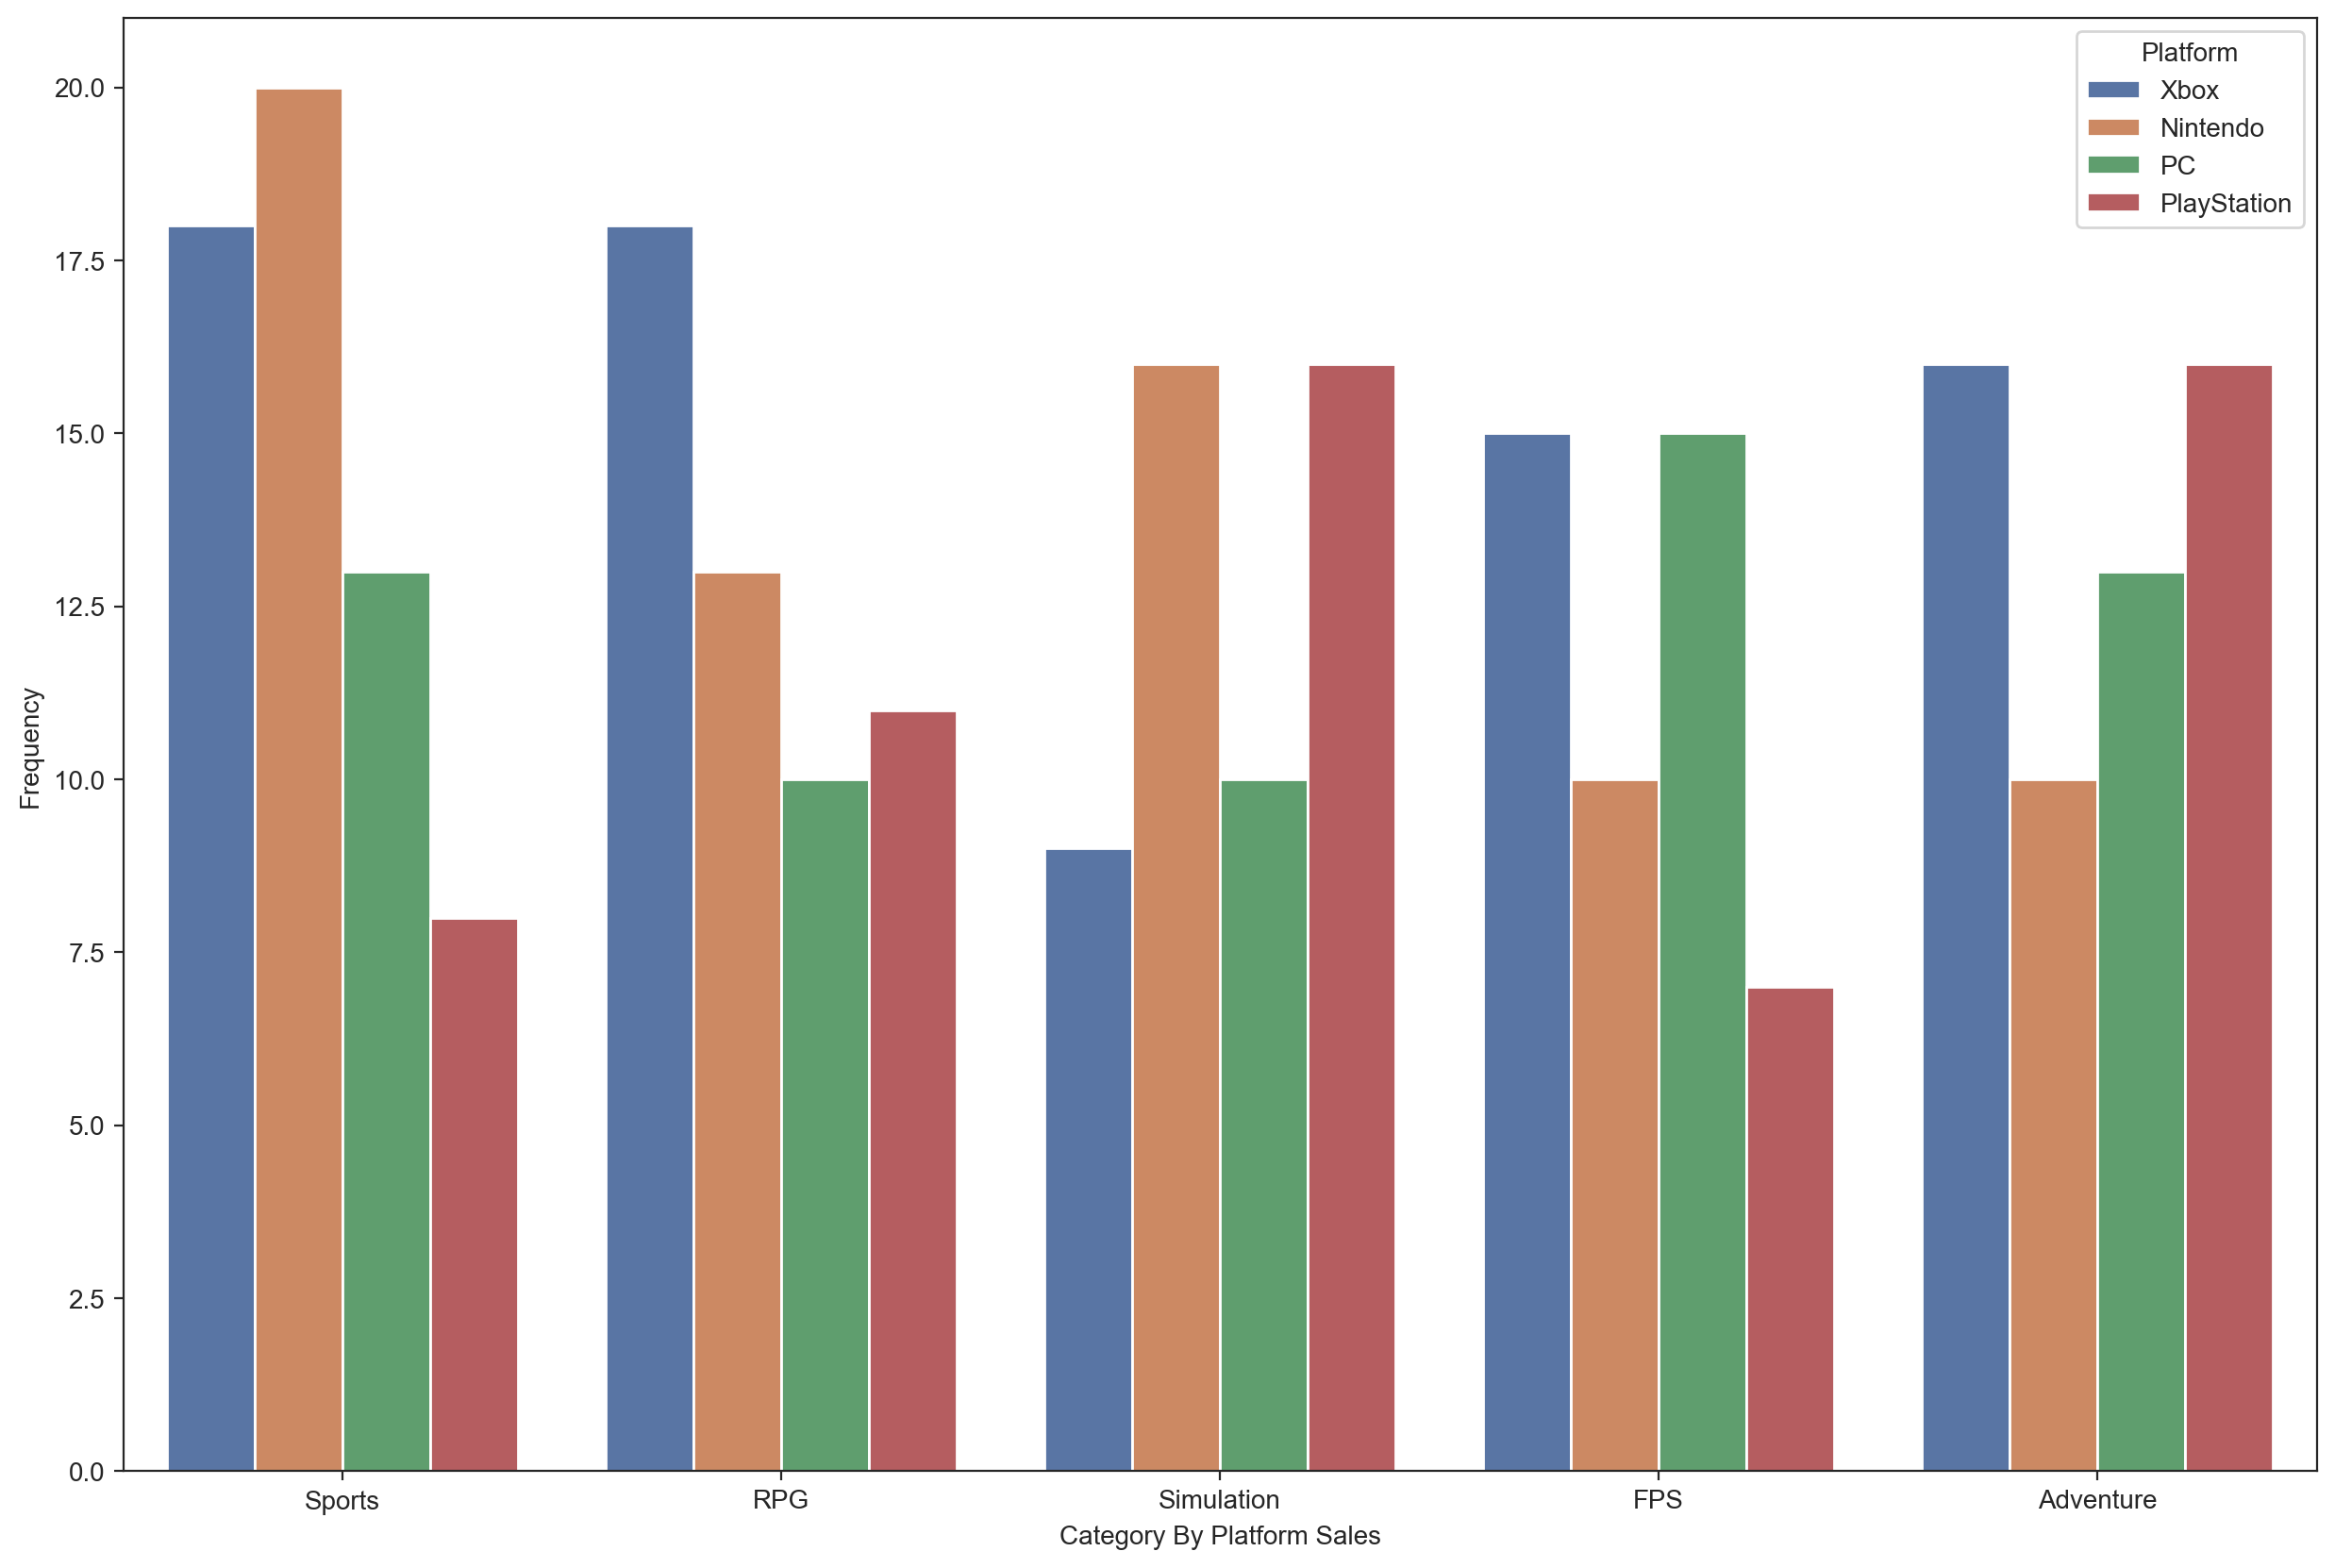

In [41]:
# Category by Year Sales
plt.figure(figsize=(15,10))

sns.countplot(data = df, x = 'Category', hue = 'Platform')

plt.xlabel("Category By Platform Sales")
plt.ylabel("Frequency")
plt.show()

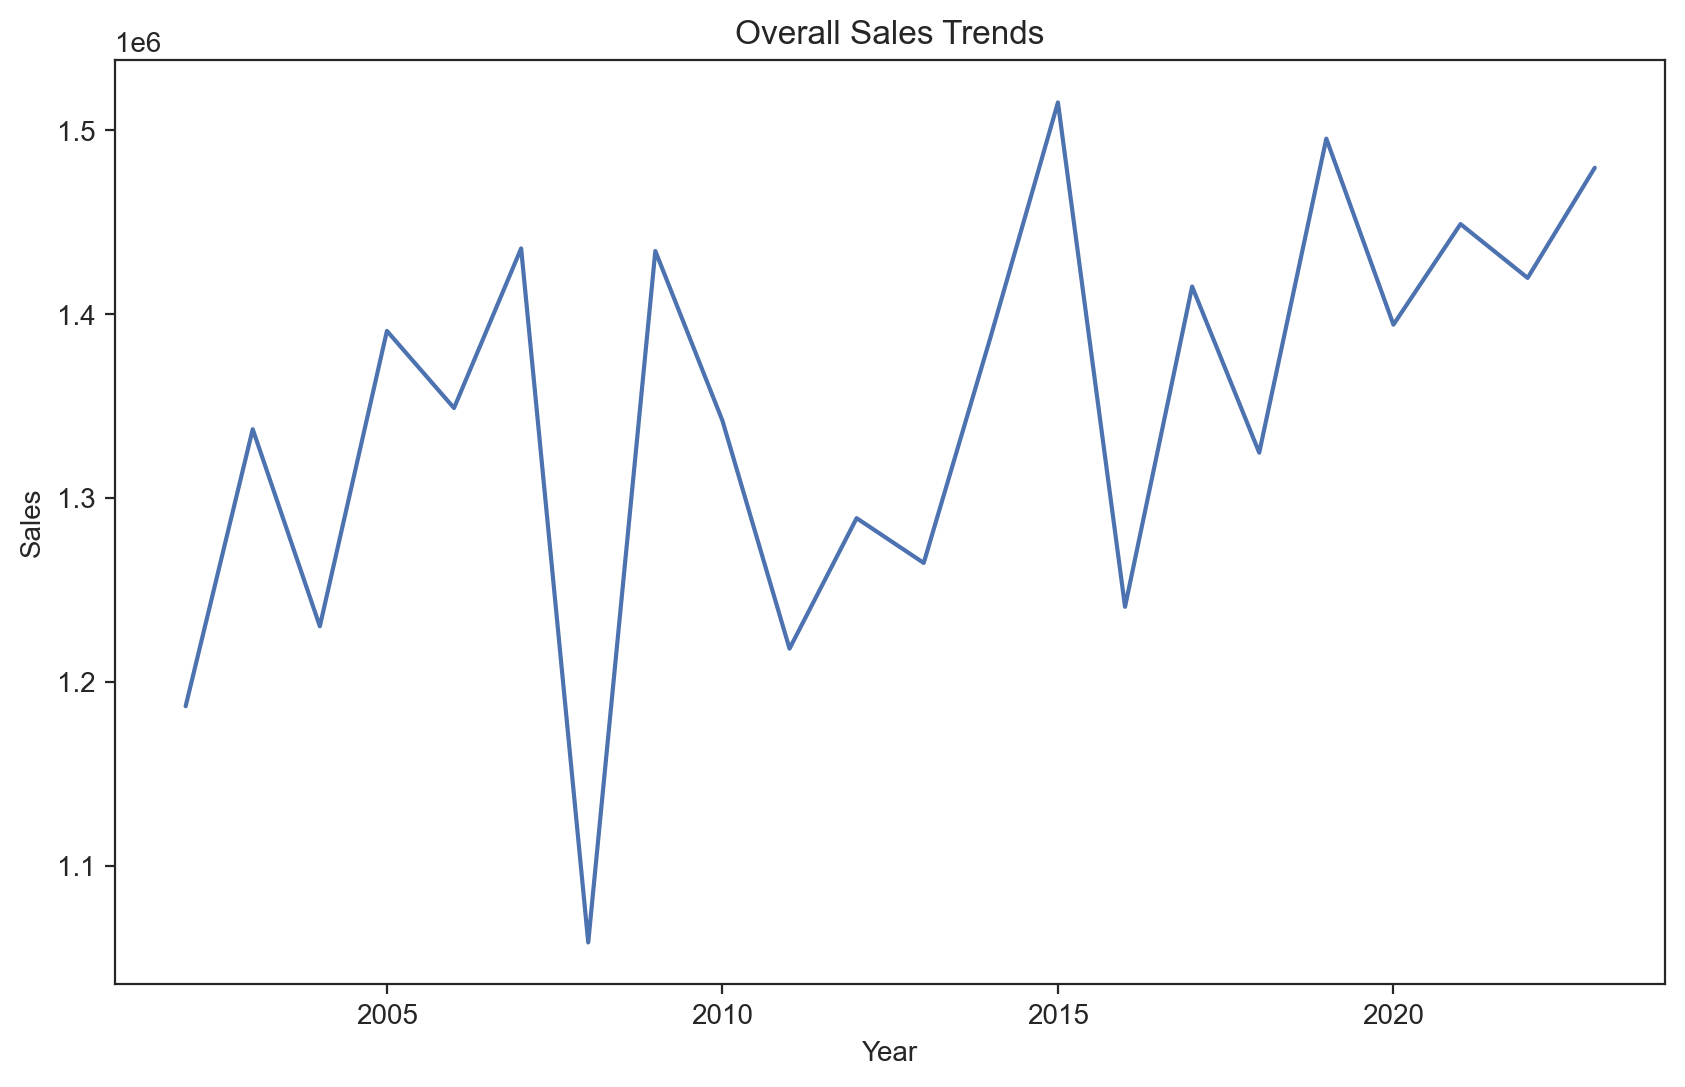

In [35]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Aggregate data for time series analysis
monthly_sales = df['Monthly Sales']

# Overall sales trends
df.groupby('Year')['Monthly Sales'].sum().plot(title="Overall Sales Trends", xlabel="Year", ylabel="Sales", figsize=(10, 6))
plt.show()

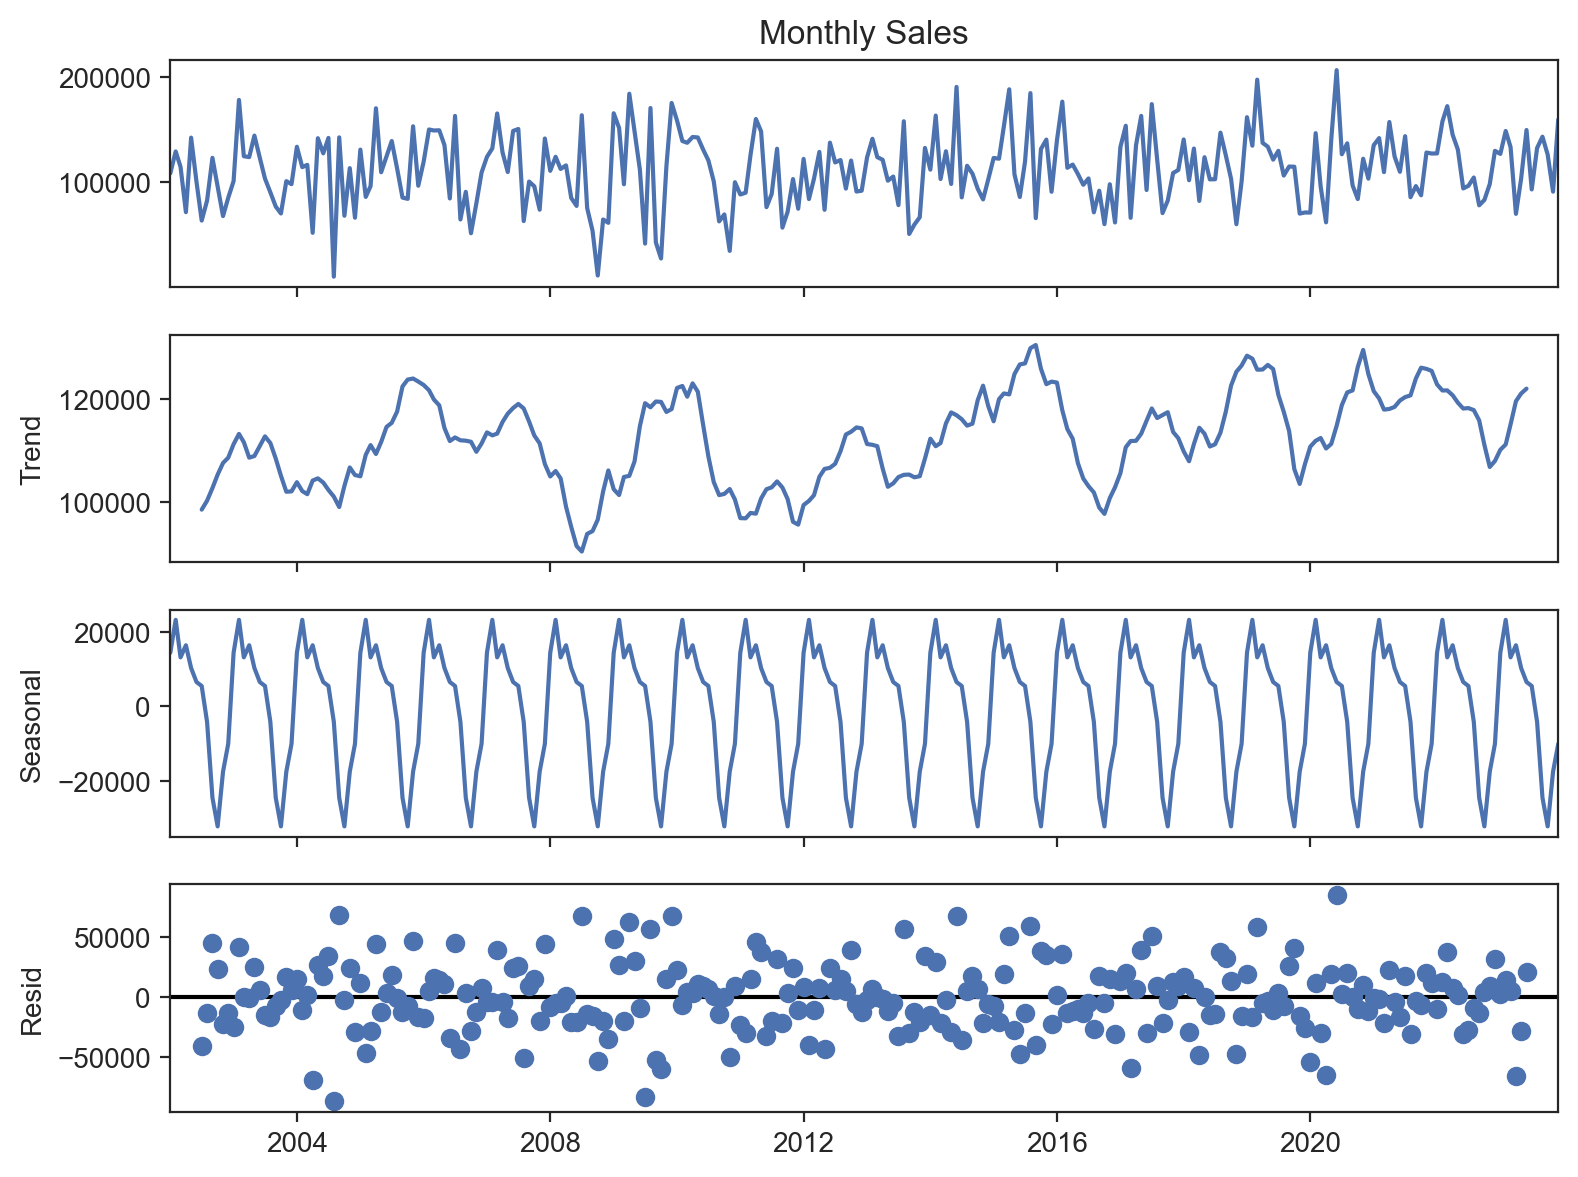

In [36]:
# Seasonal decomposition
result = seasonal_decompose(monthly_sales, model='additive', period=12)
result.plot()
plt.show()

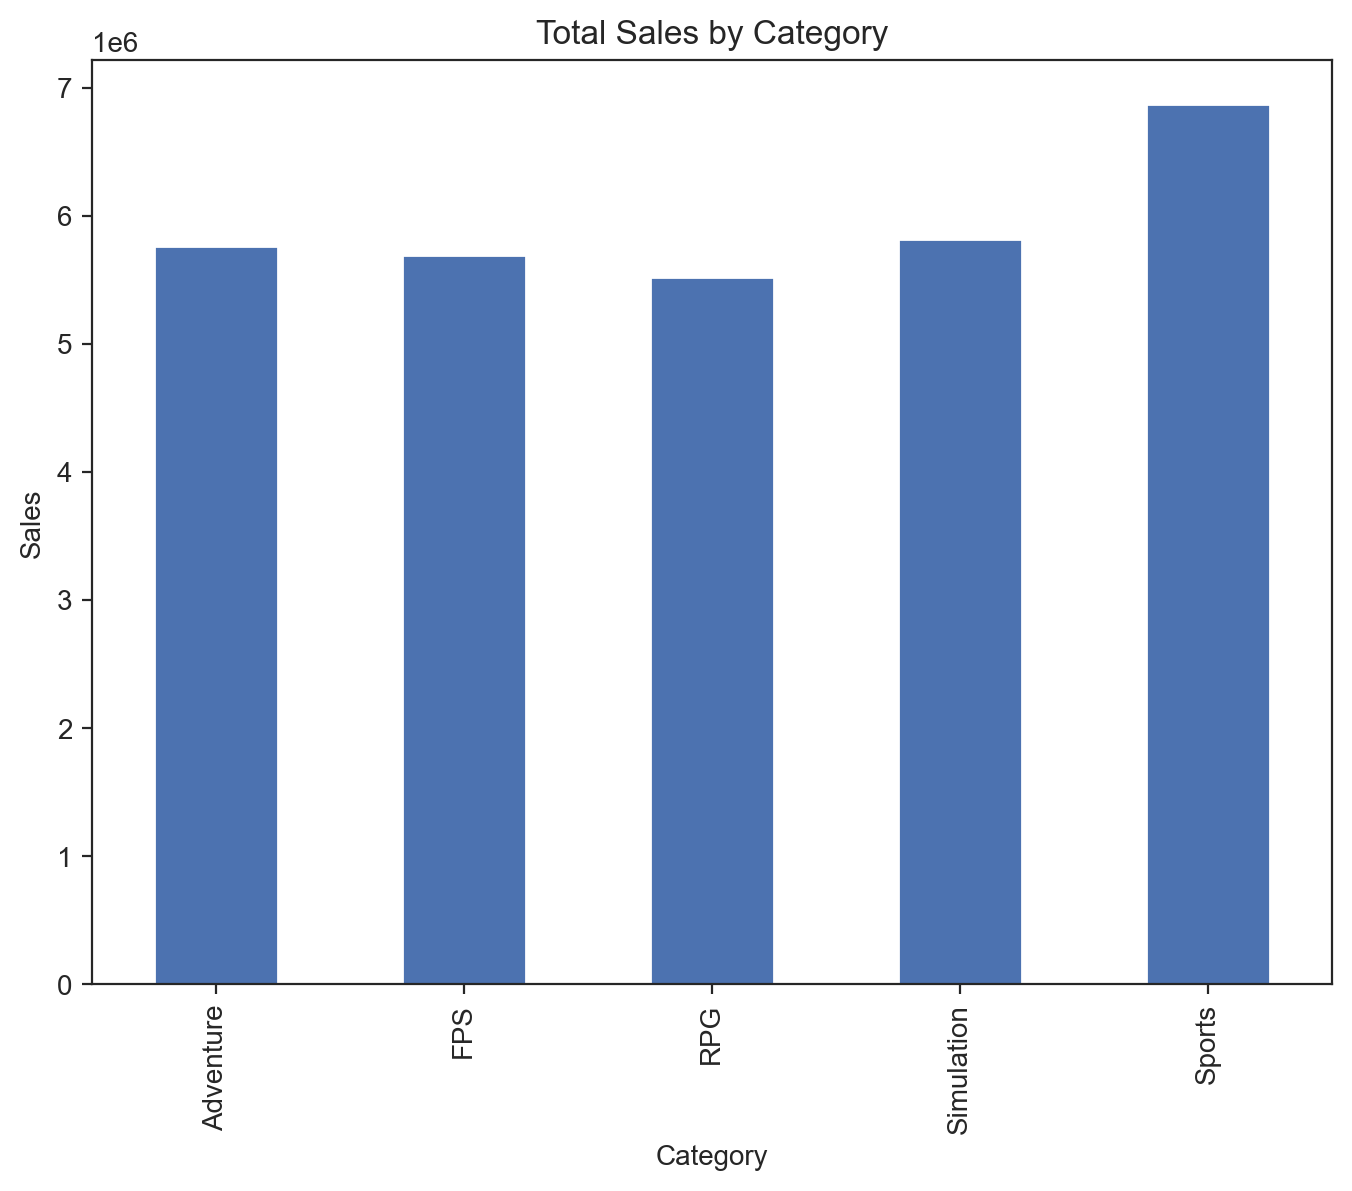

In [37]:
# Sales by Category and Platform
category_sales = df.groupby('Category')['Monthly Sales'].sum()
platform_sales = df.groupby('Platform')['Monthly Sales'].sum()

# Bar charts for sales by category and platform
category_sales.plot(kind='bar', title='Total Sales by Category', xlabel='Category', ylabel='Sales', figsize=(8, 6))
plt.show()

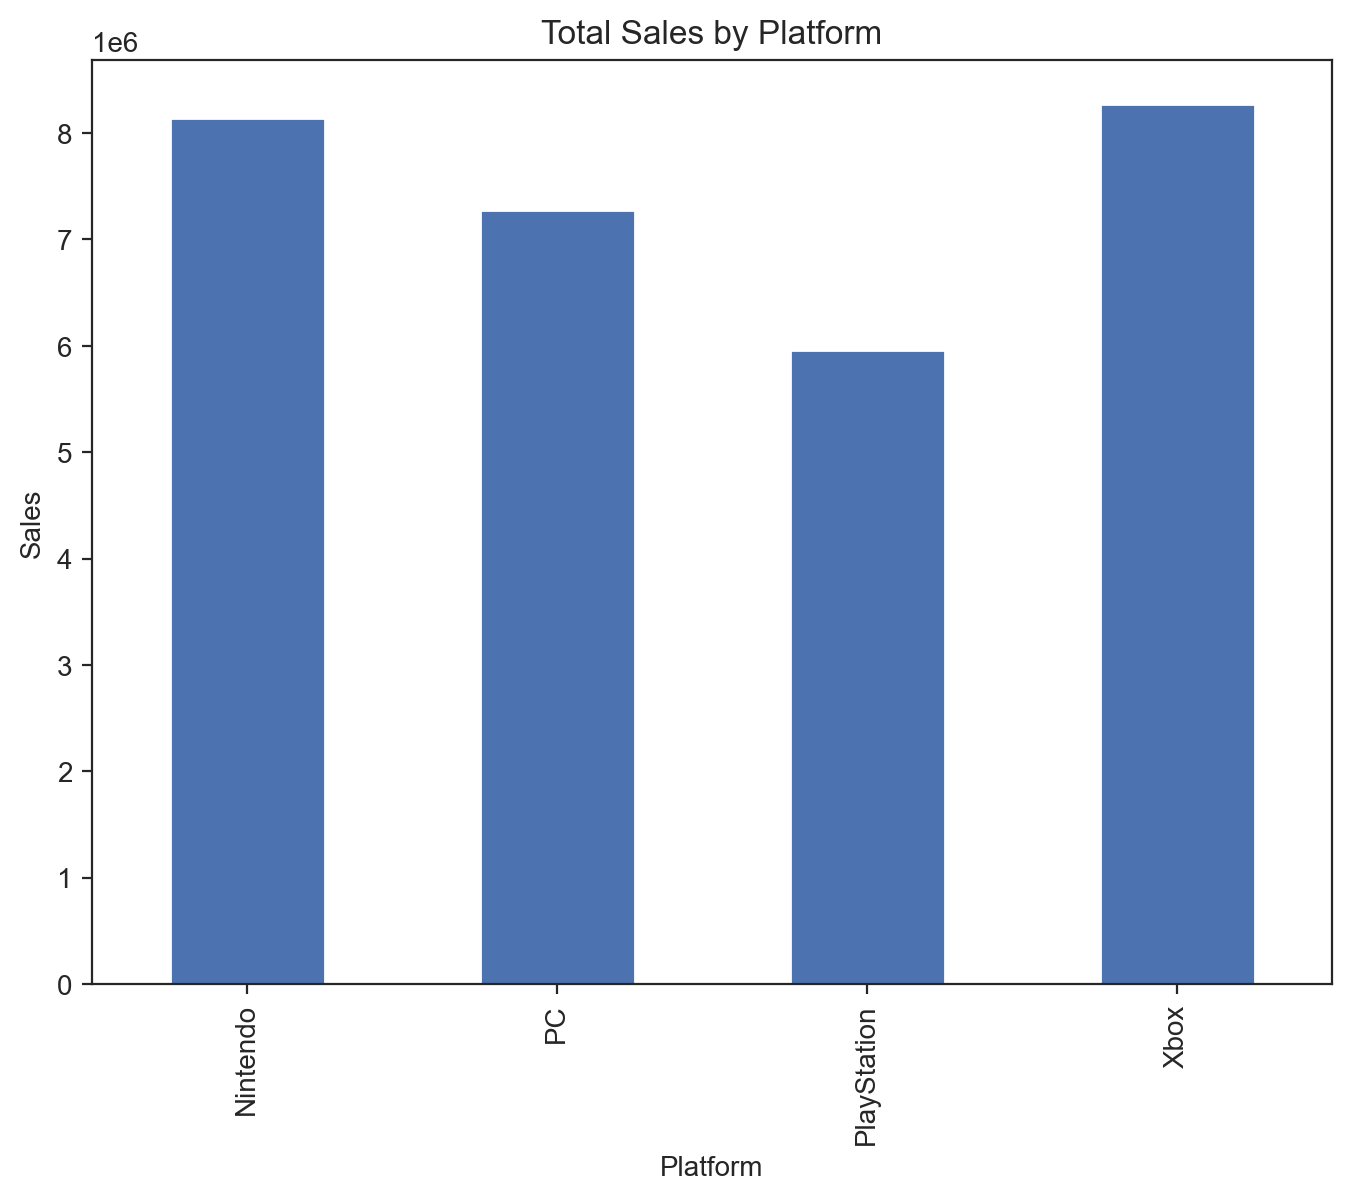

In [38]:
platform_sales.plot(kind='bar', title='Total Sales by Platform', xlabel='Platform', ylabel='Sales', figsize=(8, 6))
plt.show()

In [39]:
# Impact of Holidays and Promotions
holiday_sales = df[df['Holiday'] == 1]['Monthly Sales'].mean()
promotion_sales = df[df['Promotion'] == 1]['Monthly Sales'].mean()
print(f"Average sales during holidays: {holiday_sales}")
print(f"Average sales during promotions: {promotion_sales}")

Average sales during holidays: 114933.54545454546
Average sales during promotions: 113723.29629629629


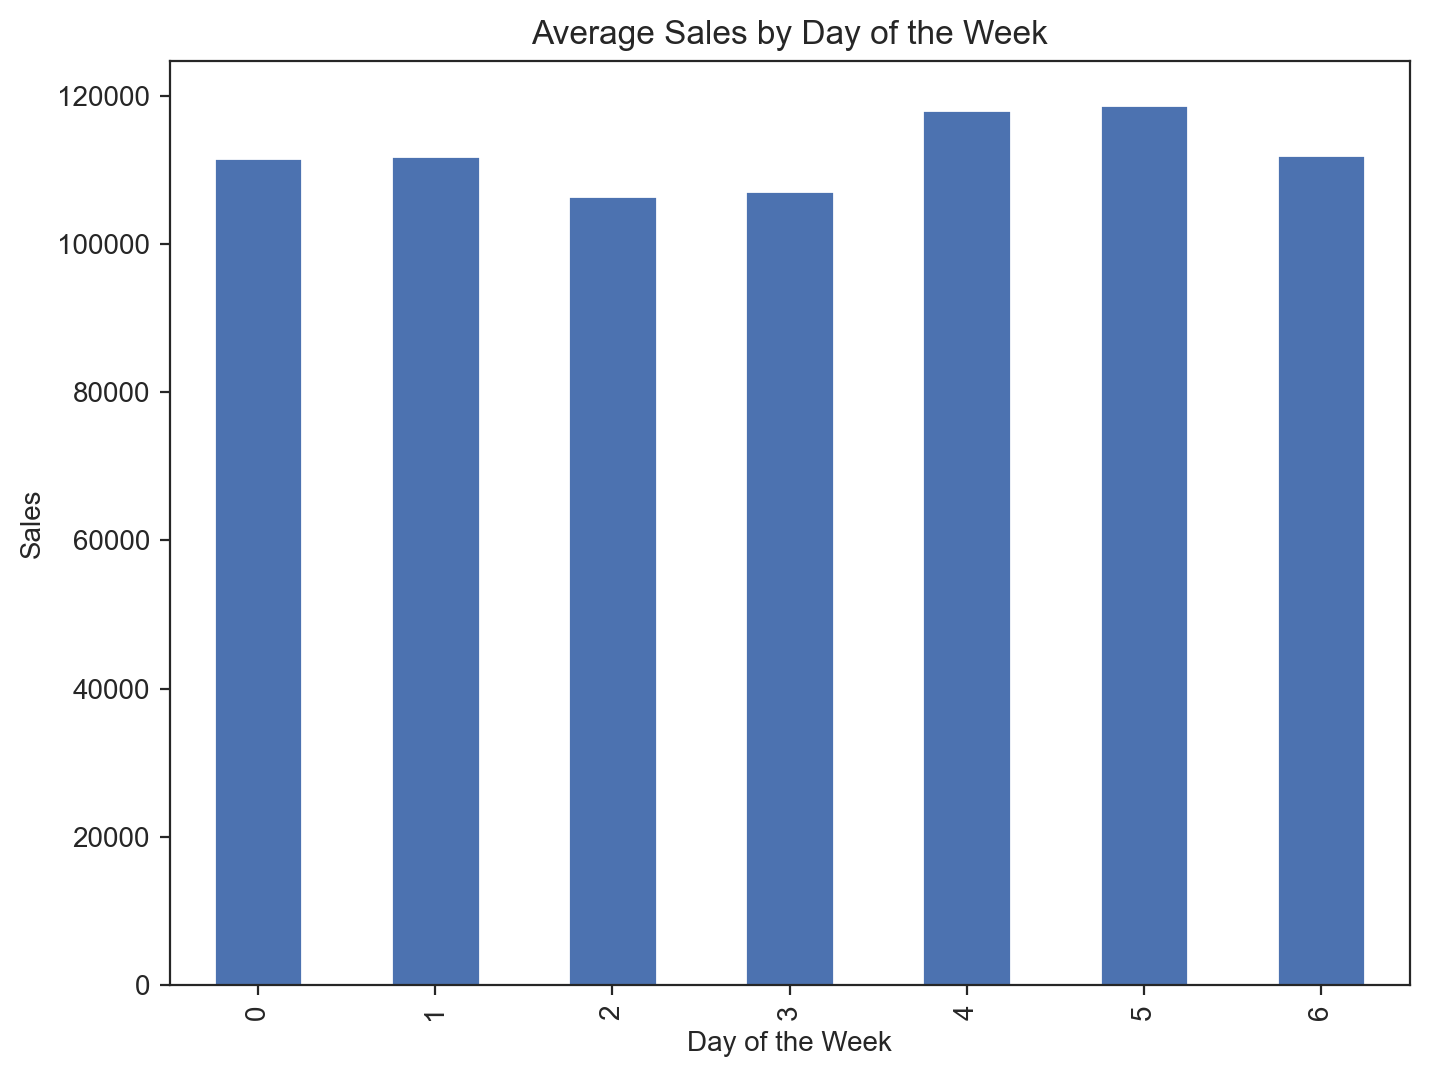

In [40]:
# Sales by day of the week
dow_sales = df.groupby('DayOfWeek')['Monthly Sales'].mean()
dow_sales.plot(kind='bar', title='Average Sales by Day of the Week', xlabel='Day of the Week', ylabel='Sales', figsize=(8, 6))
plt.show()